# Inference - Bounding Box and Angle 

## Script Setup 

In [1]:
# File Location - list of all images to evaluate. Should only contain the name of the file, not the relative/global path. 
#file_location = '../../Create-CSV-dataset/list_of_img_in_val_set_18-03.csv'
file_location = 'list_of_img_in_val_set_18-03.csv'

# TODO: implement visualization, and storing of predicted bboxes and angles. 
place_to_store_results = 'Evaluations/'

# Relative path to the folder where the image files specified in "file_location" is stored 
path_img_folder = '../../03 Data/Simple Dataset/'

# TODO implement different angle input
# 0 - regular angle (radians)
# 1 - vector half (Right half plane only), 
# 2 - vector full (Full unit circle) 
angle_representation = 1

# Defines the IOU threshold which is tested below. The stepsize used is 0.05. 
IOU_threshold_range = [0.5, 0.95]

# The threshold for how confident the classification network should before a bounding box is accepted. 
accept_BB_threshold = 0.5

## Import Packages and Libraries

In [2]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from numpy import genfromtxt
import time
import json
import copy

#NOTICE: enable when using paperspace server!!
setup_gpu(0)  

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


## Functions
### Utility

In [3]:
def area(BB):
    width = abs(BB[0] - BB[2])
    height = abs(BB[1] - BB[3])
    return height * width

def intersection(BB1, BB2):
    
    (x1, y1, x2, y2) = BB1
    (x3, y3, x4, y4) = BB2
    
    # Check if no intersection exists
    if x1 > x4 or x3 > x2 or y3 > y2 or y1 > y4:
        return 0
    
    # Find coordinates of intersection
    x5 = max(x1, x3);
    y5 = max(y1, y3);
    x6 = min(x2, x4);
    y6 = min(y2, y4);  
    BB = (x5, y5, x6, y6)
 
    return area(BB)
    
def union(BB1, BB2): 
    return area(BB1) + area(BB2) - intersection(BB1, BB2)


def count_vals(array, value):
    count = 0
    
    for val in array: 
        if val == value:
            count += 1
    return count

def format_angle(angle, test):
    formatted_angles = []
    if test == 2:
        return np.arctan2(angle[1],angle[0])/2
    elif test == 1:
        return np.arctan2(angle[1],angle[0])
    elif test == 0:
        return angle
    


def convert_rect_to_point(rect):
    x = rect[0]
    y = rect[1]
    w = rect[2]
    h = rect[3]
    x1 = x
    y1 = y
    x2 = x + w
    y2 = y + h
    
    return (x1, y1, x2, y2)

### Bounding Box and Angle Evaluations

In [4]:
def calculate_metrics_bbox(true_positive, false_negatives, false_positive):
    recall = true_positive / (true_positive + false_negatives)
    precision = true_positive / (true_positive + false_positive)
    f1 = 2 * (precision * recall) / (precision + recall) 

    return recall, precision, f1

def filter_predictions(bboxes, scores, labels, angles, score_threshold):
    filtered_bboxes = []
    filtered_scores = []
    filtered_labels = []
    filtered_angles = []
    
    for bbox, score, label, angle in zip(bboxes, scores, labels, angles):
        if score < score_threshold: 
            break
            
        filtered_bboxes.append(bbox)
        filtered_scores.append(score)
        filtered_labels.append(label)
        filtered_angles.append(format_angle(angle, angle_representation))

    return filtered_bboxes, filtered_scores, filtered_labels, filtered_angles

def match_preds_with_annotations(bbox_annotations, bbox_predictions, IOU_threshold):
    # match_index_annotations - 
    # match_index_predictions - 

    # Initialize index vectors with -1, which indicates no match has been found.  
    match_index_annotations = [-1 for x in range(len(bbox_annotations))]; 
    match_index_predictions =  [-1 for x in range(len(bbox_predictions))]; 
    
    for idx, annotation in enumerate(bbox_annotations): 
        max_IOU = 0
        for i in range(len(bbox_predictions)):
            
             # check if current prediction is contained in annotation 
            if(i not in match_index_annotations):
                
                if intersection(annotation, bbox_predictions[i]) > 0: #convert_rect_to_point only for tests
                    IOU = intersection(annotation, bbox_predictions[i])/union(annotation, bbox_predictions[i])

                    if(IOU > max_IOU):
                        max_IOU_index = i
                        max_IOU = IOU
                        
        if max_IOU > IOU_threshold:
            match_index_annotations[idx] = max_IOU_index
            match_index_predictions[max_IOU_index] = idx
    
    return match_index_annotations, match_index_predictions


def evaluate_bounding_boxes(match_index_annotations, match_index_predictions):
    
    false_negatives = count_vals(match_index_annotations, -1)
    true_positive = len(match_index_annotations) - false_negatives
    false_positive = count_vals(match_index_predictions, -1)

    return true_positive, false_negatives, false_positive


def error_angles(match_index_predictions, angle_annotations, angle_predictions):
    # Caluclates the error between the predicted and annotated angle  
    error_list = []
   
    for idx_pred, idx_anno in enumerate(match_index_predictions):
        if idx_anno != -1:
            error_list.append(min([angle_predictions[idx_pred] - angle_annotations[idx_anno],
                 angle_predictions[idx_pred] - angle_annotations[idx_anno] + np.pi, 
                 angle_predictions[idx_pred] - angle_annotations[idx_anno] - np.pi], key=abs))
            
            
    return error_list

def calculate_mse(error_list):
    squared_list = []
    
    # Flatten error list 
    flattened_error = [val for sublist in error_list for val in sublist]
    
    for error in flattened_error: 
        squared_list.append(error**2)
        
    mse = sum(squared_list) / len(squared_list)
    
    return mse


### File Handling

In [5]:
def read_annotations(image_path):

    with open('..' + image_path.strip('.png') + '.json') as json_file:
        
        data = json.load(json_file)
        shapes_list = data['shapes']
        bbox_list = []
        labels_list = []
        angle_list = []
        
        for bbox in shapes_list: 
            rect = cv2.boundingRect(np.float32(bbox['points']))
            bbox_list.append(convert_rect_to_point(rect))
            labels_list.append(0)
            rot_rect = cv2.minAreaRect(np.float32(bbox['points']))
            if rot_rect[-2][0] < rot_rect[-2][1]:
                rot_rect = (rot_rect[0],(rot_rect[-2][1],rot_rect[-2][0]),rot_rect[-1]+90)
            # make sure that no angle is above 90 or below -90
            if rot_rect[-1] > 90:
                rot_rect = (rot_rect[0],rot_rect[1],rot_rect[-1]-180)
            if rot_rect[-1] < -90:
                rot_rect = (rot_rect[0],rot_rect[1],rot_rect[-1]+180)
            angle_list.append(rot_rect[-1]/180*np.pi)            
    
    return bbox_list, labels_list, angle_list

def import_rows_from_csv(csv_path):
    file = open(csv_path)
    row_list = []
    
    for row in file: 
        row_list.append(row.strip('\n'))
    
    return row_list

### Visualisation

In [6]:
def draw_predictions():
    return

## Load Model - Convert to Inference Model 

In [7]:
%%capture

# import model
model_path = os.path.join('snapshots', 'Right_Half_Plane_L1_05_resnet50_csv_25.h5');
model = models.load_model(model_path, backbone_name='resnet50');

# If model is not converted to inference model, use line below: 
model = models.convert_model(model);

# Mapping of model output and classes
labels_to_names = {0: 'Brick'};

## Evaluate Bounding Boxes (TODO: and Angles)

In [8]:
# Import paths of all images to evaluate
file_list = import_rows_from_csv(file_location)
#file_list = file_list[-2:-1]

IOU_thres = np.arange(IOU_threshold_range[0], IOU_threshold_range[1] + 0.05, 0.05).tolist()
recall_list = []
precision_list = []
f1_list = []

annotations = []
predictions = []

# Load predictions and annotations, store on the list annotations and predictions. Each entry represents an image. 
for file in file_list: 
    # Import image, preprocess and resize as specified in the Keras Retinanet implementation
    image = read_image_bgr(path_img_folder + file)
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # Get prediction on current image 
    boxes, scores, labels, angles = model.predict_on_batch(np.expand_dims(image, axis=0))
    boxes /= scale
    boxes, scores, labels, angles = filter_predictions(boxes[0], scores[0], labels[0], angles[0], accept_BB_threshold)
    predictions.append([boxes, scores, labels, angles])
    
    # Load Annotation for curret image 
    boxes, label, angles = read_annotations(path_img_folder + file)
    annotations.append([boxes, labels, angles])

#print("annotations: ", annotations)
#print("predictions: ",predictions)
# Evaluate Average Precision of predicions
# http://cocodataset.org/#detection-leaderboard - (AP at IoU=.50:.05:.95)
for IOU_threshold in IOU_thres:
    
    total_true_pos  = 0 
    total_false_neg = 0
    total_false_pos = 0
    angle_error_list = []
    
    for annotation, prediction in zip(annotations, predictions):
        
        boxes_pred, scores_pred, labels_pred, angles_pred = prediction
        boxes_anno, labels_anno, angles_anno = annotation
        
        # Match prediction with Annotations and visa vice
        match_annotations, match_predictions = match_preds_with_annotations(boxes_anno, boxes_pred, IOU_threshold)
        
        #print("match annotation: ", match_annotations, "match prediction: ", match_predictions )
        
        true_pos, false_neg, false_pos = evaluate_bounding_boxes(match_annotations, match_predictions)
        
        angle_error_list.append(error_angles(match_predictions, angles_anno, angles_pred))
        
        total_true_pos  += true_pos
        total_false_neg += false_neg
        total_false_pos += false_pos
        
    mse = calculate_mse(angle_error_list)
    print("IOU Threshold: %.2f MSE: %.15f" % (IOU_threshold, mse))
    #print("IOU Threshold: ", IOU_threshold, "   MSE: ", mse)
    recall, precision, f1 = calculate_metrics_bbox(total_true_pos, total_false_neg, total_false_pos)
    recall_list.append(recall)
    precision_list.append(precision)
    f1_list.append(f1)

IOU Threshold: 0.50 MSE: 0.000537033391676
IOU Threshold: 0.55 MSE: 0.000536867848511
IOU Threshold: 0.60 MSE: 0.000537890035813
IOU Threshold: 0.65 MSE: 0.000538386352547
IOU Threshold: 0.70 MSE: 0.000531697764005
IOU Threshold: 0.75 MSE: 0.000531821601557
IOU Threshold: 0.80 MSE: 0.000532328956090
IOU Threshold: 0.85 MSE: 0.000490116317333
IOU Threshold: 0.90 MSE: 0.000445387694705
IOU Threshold: 0.95 MSE: 0.000410049869039


## Results 

### Average precision for bouding box predictions

Avg. precision: 0.8521609538002981
Avg. recall:    0.8934375000000001
Avg. F1:        0.8723112128146454


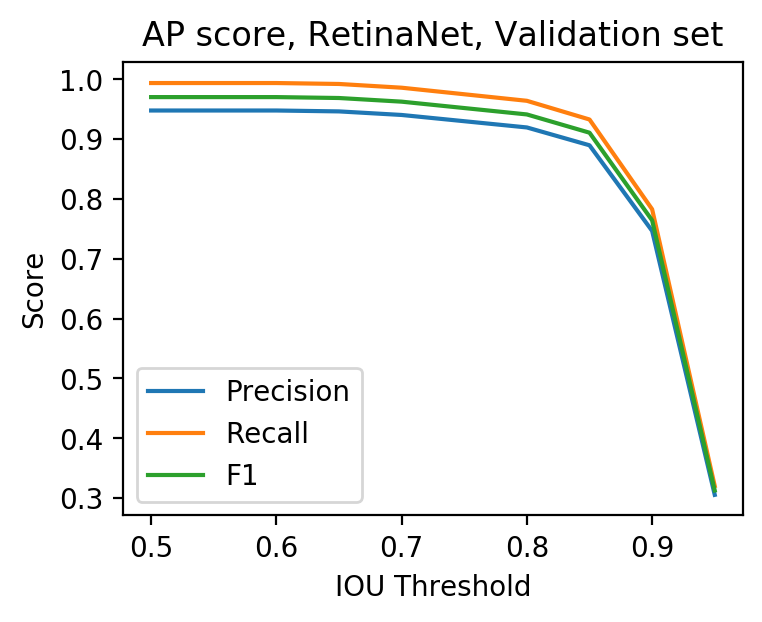

In [9]:
plt.figure(figsize=(4, 3), dpi=200)
plt.plot(IOU_thres, precision_list)
plt.plot(IOU_thres, recall_list)
plt.plot(IOU_thres, f1_list)
plt.legend(['Precision', 'Recall', 'F1'])
plt.title('AP score, RetinaNet, Validation set')
plt.ylabel('Score')
plt.xlabel('IOU Threshold')


average_precision = np.average(precision_list)
average_recall = np.average(recall_list)
average_f1 = np.average(f1_list)

print('Avg. precision:', average_precision)
print('Avg. recall:   ', average_recall)
print('Avg. F1:       ', average_f1)

In [10]:
print("Precision: ", precision_list)
print("Recall: ", recall_list)
print("f1_list: ", f1_list)

Precision:  [0.9478390461997019, 0.9478390461997019, 0.9478390461997019, 0.9463487332339792, 0.940387481371088, 0.9299552906110283, 0.9195230998509687, 0.8897168405365127, 0.7466467958271237, 0.3055141579731744]
Recall:  [0.99375, 0.99375, 0.99375, 0.9921875, 0.9859375, 0.975, 0.9640625, 0.9328125, 0.7828125, 0.3203125]
f1_list:  [0.9702517162471397, 0.9702517162471397, 0.9702517162471397, 0.9687261632341724, 0.9626239511823035, 0.9519450800915331, 0.9412662090007627, 0.9107551487414189, 0.7643020594965674, 0.3127383676582761]
